In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import sys

import matplotlib.patches as patches
import matplotlib.pyplot as plt

sys.path.append("..")

import gc
import os
import subprocess
from collections.abc import Iterable
from concurrent.futures import ProcessPoolExecutor
from glob import glob
from os.path import abspath, dirname, join
from statistics import mode

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch.optim
from IPython.display import HTML, display
from joblib import Parallel, delayed
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
from millify import millify
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from scipy.ndimage import distance_transform_edt, gaussian_filter
from seaborn import color_palette
from skimage import transform
from skimage.color import label2rgb
# load label
from skimage.measure import find_contours, label
from skimage.morphology import remove_small_holes, remove_small_objects
from tqdm import tqdm

from pred2raster import pred2raster
from sample_selection import get_components_stats, filter_components_by_geometric_property, filter_components_by_mask
from src.io_operations import (fix_relative_paths, load_args, read_tiff,
                               read_yaml)
from utils import *

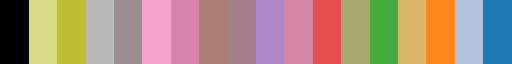

In [54]:
color_black = "#000000"
colors = color_palette("tab20", 18).as_hex()
colors.reverse()
colors = [color_black] + colors
cmap = LinearSegmentedColormap.from_list("mycmap", colors, N=18)
cmap

In [55]:
INPUT_FOLDER = "../amazon_input_data"
VERSAO = "13_2x_amazon_data"
ITER_FOLDER = "iter_001"

In [56]:
args = load_args(join(ROOT_PATH, VERSAO, "args.yaml"))

In [57]:
ORTHOIMAGE = read_tiff(args.ortho_image)
ORTHOIMAGE = np.moveaxis(ORTHOIMAGE, 0, 2)

In [58]:
ORTHOIMAGE.shape

(11433, 26104, 3)

In [59]:
LABEL_GT_TRAIN = read_tiff(args.train_segmentation_path)

LABEL_GT_TEST = read_tiff(args.test_segmentation_path)

MASK = read_tiff(args.mask_path)

In [60]:
TRAIN_DISTANCE_MAP = read_tiff(join(ROOT_PATH, VERSAO, "iter_000", "distance_map","train_distance_map.tif"))

In [61]:
COMP_TEST_GT = label(LABEL_GT_TEST)
COMP_TRAIN_GT = label(LABEL_GT_TRAIN)

In [62]:
class_pred = read_tiff(
    glob(join(ROOT_PATH, VERSAO, ITER_FOLDER, "raster_prediction", "join_class*"))[0]
)+1

depth_pred = read_tiff(
    glob(join(ROOT_PATH, VERSAO, ITER_FOLDER, "raster_prediction", "depth*"))[0]
)
depth_pred = np.float32(depth_pred) / 255


prob_pred = read_tiff(
    glob(join(ROOT_PATH, VERSAO, ITER_FOLDER, "raster_prediction", "join_prob*"))[0]
)
prob_pred = np.float32(prob_pred) / 255

In [63]:
num_classes = pd.unique(pd.Series(class_pred.ravel())).shape[0]

In [64]:
DEFAULT_COLORS = color_palette("tab20", num_classes)
DEFAULT_COLORS.insert(0, (0,0,0))

In [65]:
##### Generate visualization 
colors = np.array([(0,0,0)] + list(color_palette("tab20", 18)))

In [66]:
scale = 1
window_selected = slice(int(8000*scale), int(scale*10_500)), slice(int(scale*12_000), int(scale*15_000))

prob_selected = prob_pred[window_selected]
depth_selected = depth_pred[window_selected]
class_selected = class_pred[window_selected]


prob_gauss = gaussian_filter(prob_selected, sigma = 20)
depth_gauss = gaussian_filter(depth_selected, sigma = 30)

In [67]:
prob_mask = prob_gauss > 0.7
depth_mask = depth_gauss > 0.35

high_prob_pred = np.where(prob_mask, class_selected, 0)
high_prob_depth_pred = np.where(prob_mask & depth_mask, class_selected, 0)

In [68]:
window_high_prob = high_prob_pred.copy()
# mask_small = remove_small_objects(window_high_prob.astype(bool), min_size=3000)
# window_high_prob[~mask_small] = 0

window_high_prob_depth = high_prob_depth_pred.copy()

window_cleaned = window_high_prob_depth.copy()
mask_small = remove_small_objects(window_cleaned.astype(bool), min_size=25_000)
window_cleaned[~mask_small] = 0

label_gt_train_selected = LABEL_GT_TRAIN[window_selected].copy()

In [69]:
old_pred_map = LABEL_GT_TRAIN.copy()
new_pred_map = window_cleaned.copy()

mask = np.where(new_pred_map>0, True, False)
mask = remove_small_holes(mask, area_threshold=args.lower_limit_area//5)
new_pred_map = np.where(mask, new_pred_map, 0)

# filter components too small or too large
filter_components_by_geometric_property(new_pred_map, 
                                        low_limit = np.float32(args.lower_limit_area), 
                                        high_limit = np.float32(args.upper_limit_area), # high limit area
                                        property = "area")


# Calculate main metrics of each tree
comp_old_pred = COMP_TRAIN_GT.copy()
comp_old_stats = get_components_stats(comp_old_pred, old_pred_map).reset_index()

comp_old_stats = comp_old_stats.groupby("tree_type").agg(
    {"extent":"median", 
    "solidity":"median", 
    "eccentricity":"median", 
    "area":"median"
    }
)


comp_old_stats.columns  = "ref_" + comp_old_stats.columns 

# Get metrics about the new labels
comp_new_pred = label(new_pred_map)
print(comp_new_pred.max())
comp_new_stats = get_components_stats(comp_new_pred, new_pred_map).reset_index()

# Join data from the last with the new one
comp_new_stats = comp_new_stats.merge(comp_old_stats, on = "tree_type", how = "left")

comp_new_stats["diff_area"] =  (comp_new_stats["area"] - comp_new_stats["ref_area"])/comp_new_stats["ref_area"]
comp_new_stats["diff_soli"] =  (comp_new_stats["solidity"] - comp_new_stats["ref_solidity"])
comp_new_stats["diff_ecc"] =  (comp_new_stats["eccentricity"] - comp_new_stats["ref_eccentricity"])

median_filter = (
    # (comp_new_stats["diff_area"] <= np.float32(args.upper_limit_area_rlted_to_tree_type)) & 
    (comp_new_stats["diff_area"] >= np.float32(args.lower_limit_area_rlted_to_tree_type)) 
    # (comp_new_stats["diff_soli"] >= np.float32(args.lower_limit_solidity_rlted_to_tree_type))
)
print(median_filter.sum())

# Select componentes based on some metrics
selected_comp = comp_new_stats[median_filter].copy()

new_pred_map =  np.where(np.isin(comp_new_pred, selected_comp["label"].unique()), new_pred_map, 0)

13
11


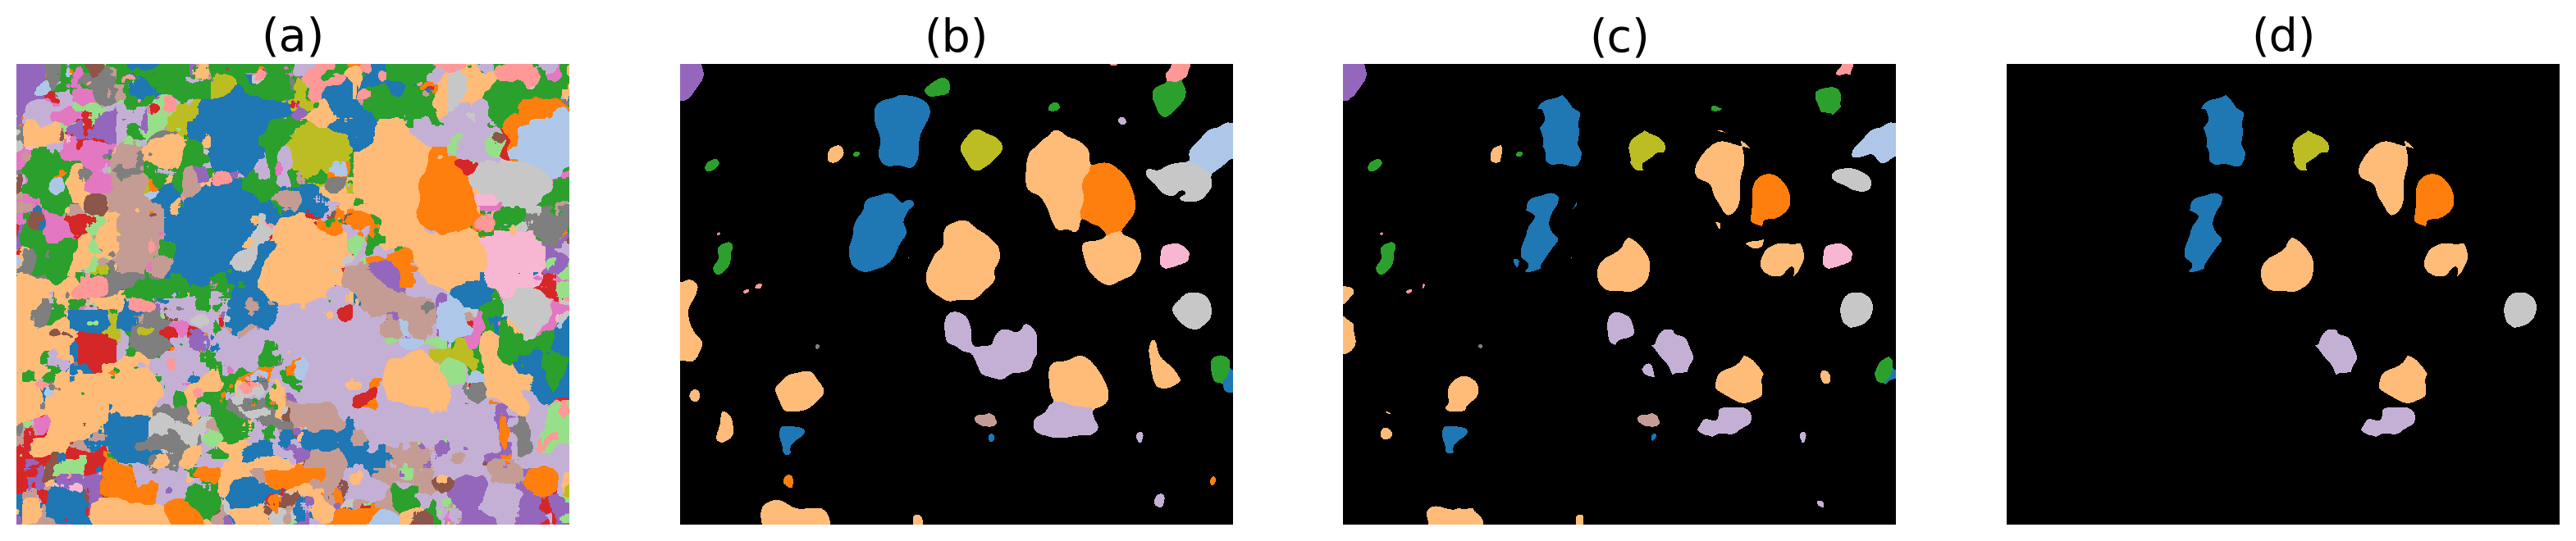

In [70]:

fig, ax = plt.subplots(1, 4, figsize=(20, 8), dpi=200)
fontsize = 20

ax[0].set_title("(a)", fontsize=fontsize)
ax[0].imshow(colors[class_selected], interpolation="nearest")

ax[1].set_title("(b)", fontsize=fontsize)
ax[1].imshow(colors[window_high_prob], interpolation="nearest")

ax[2].set_title("(c)", fontsize=fontsize)
ax[2].imshow(colors[window_high_prob_depth], interpolation="nearest")

ax[3].set_title("(d)", fontsize=fontsize)
ax[3].imshow(colors[new_pred_map], interpolation="nearest")


for a in ax:
    a.axis("off")

# save as pdf
fig.savefig("figures/sample_selection_process.pdf", bbox_inches="tight", format="pdf")
plt.show()

In [71]:
prob_selected = prob_pred[window_selected]
depth_selected = depth_pred[window_selected]
class_selected = class_pred[window_selected].copy()


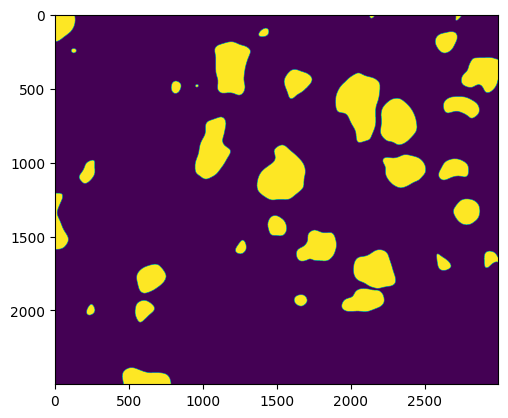

In [72]:
plt.imshow((prob_gauss + depth_gauss)>1.2)

In [73]:
selected_itc

array([[9, 9, 9, ..., 0, 0, 0],
       [9, 9, 9, ..., 0, 0, 0],
       [9, 9, 9, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

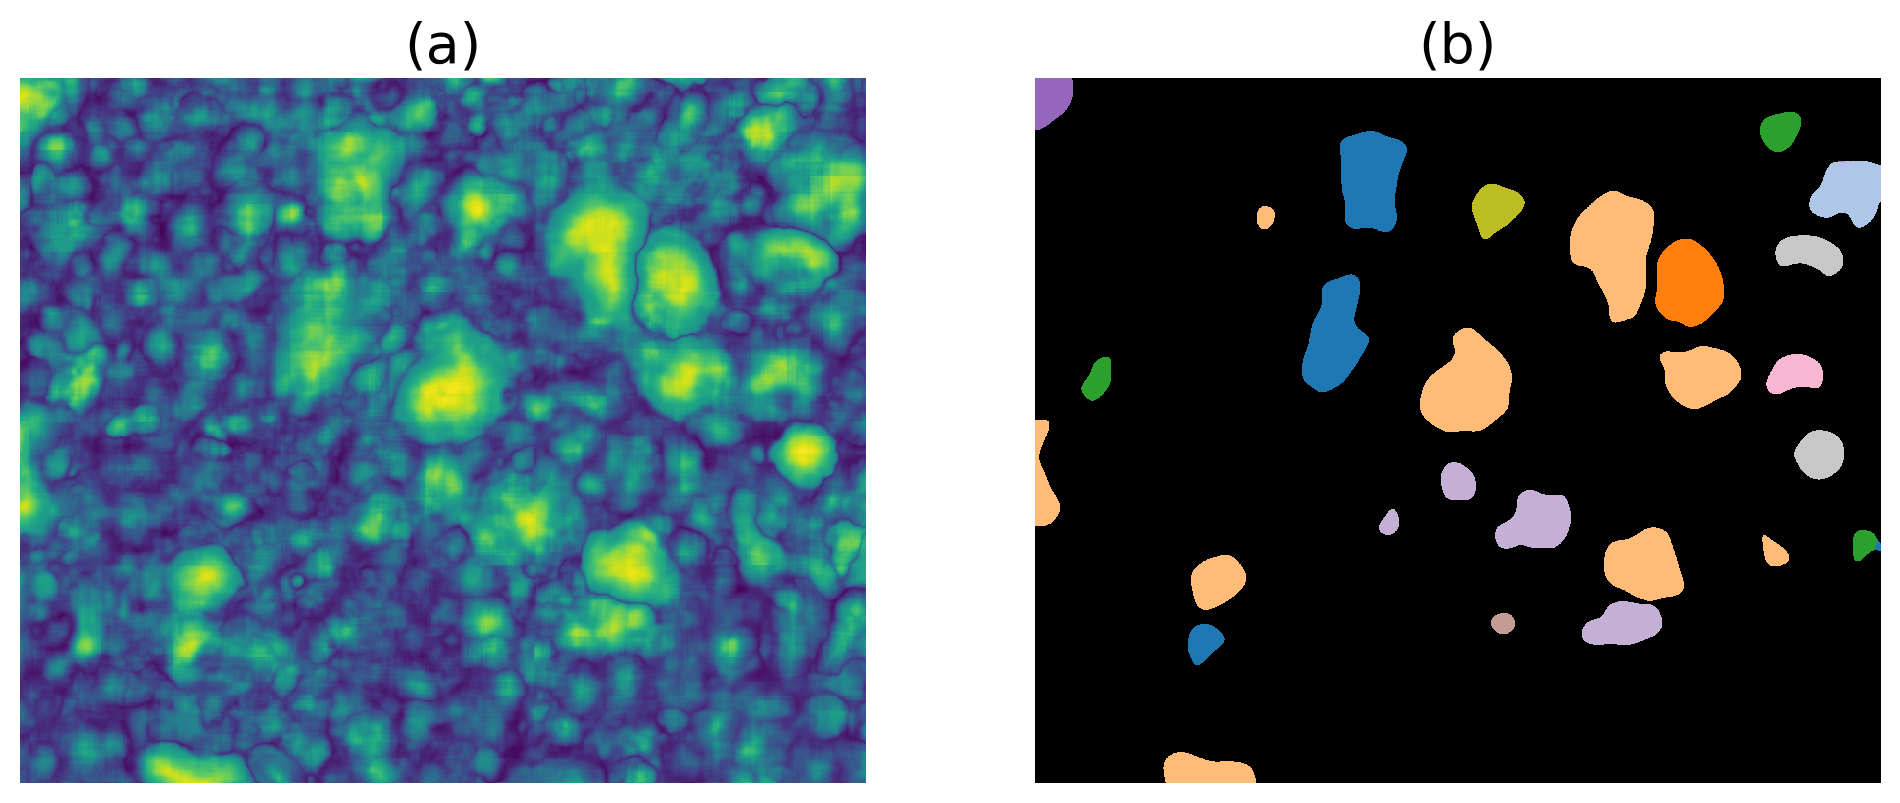

In [79]:



fig, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=200)
fontsize = 20

ax[0].set_title("(a)", fontsize=fontsize)
ax[0].imshow(prob_selected + depth_selected, interpolation="nearest")

selected_itc = np.where((prob_gauss + depth_gauss)>1.2, class_selected, 0)

# remove small objects
mask_small = remove_small_objects(selected_itc.astype(bool), min_size=3000)
selected_itc[~mask_small] = 0


ax[1].set_title("(b)", fontsize=fontsize)
ax[1].imshow(colors[selected_itc], interpolation="nearest")



for a in ax:
    a.axis("off")

# save as pdf
fig.savefig("figures/simposio_sample_selection.pdf", bbox_inches="tight", format="pdf")

plt.show()

# plt.imshow()